# Pearson correlation

Pandas computed Pearson r: 0.206
Scipy computed Pearson r: 0.206 and p-value: 3.79e-51


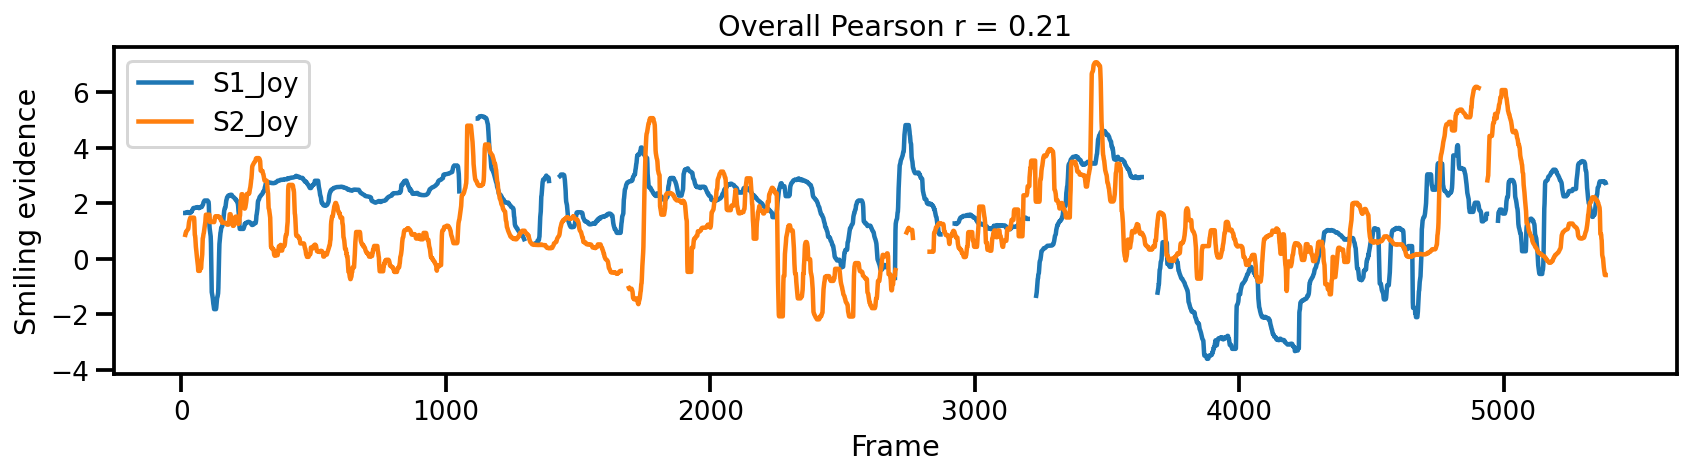

In [2]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
sns.set_context('talk',font_scale=.8)

df = pd.read_csv('synchrony_sample.csv')
overall_pearson_r = df.corr().iloc[0,1]
print(f"Pandas computed Pearson r: {overall_pearson_r:.3g}")

r, p = stats.pearsonr(df.dropna()['S1_Joy'], df.dropna()['S2_Joy'])
print(f"Scipy computed Pearson r: {r:.3g} and p-value: {p:.3g}")

f,ax=plt.subplots(figsize=(14,3))
df.rolling(window=30,center=True).median().plot(ax=ax)
ax.set(xlabel='Frame',ylabel='Smiling evidence',title=f"Overall Pearson r = {overall_pearson_r:.2g}");

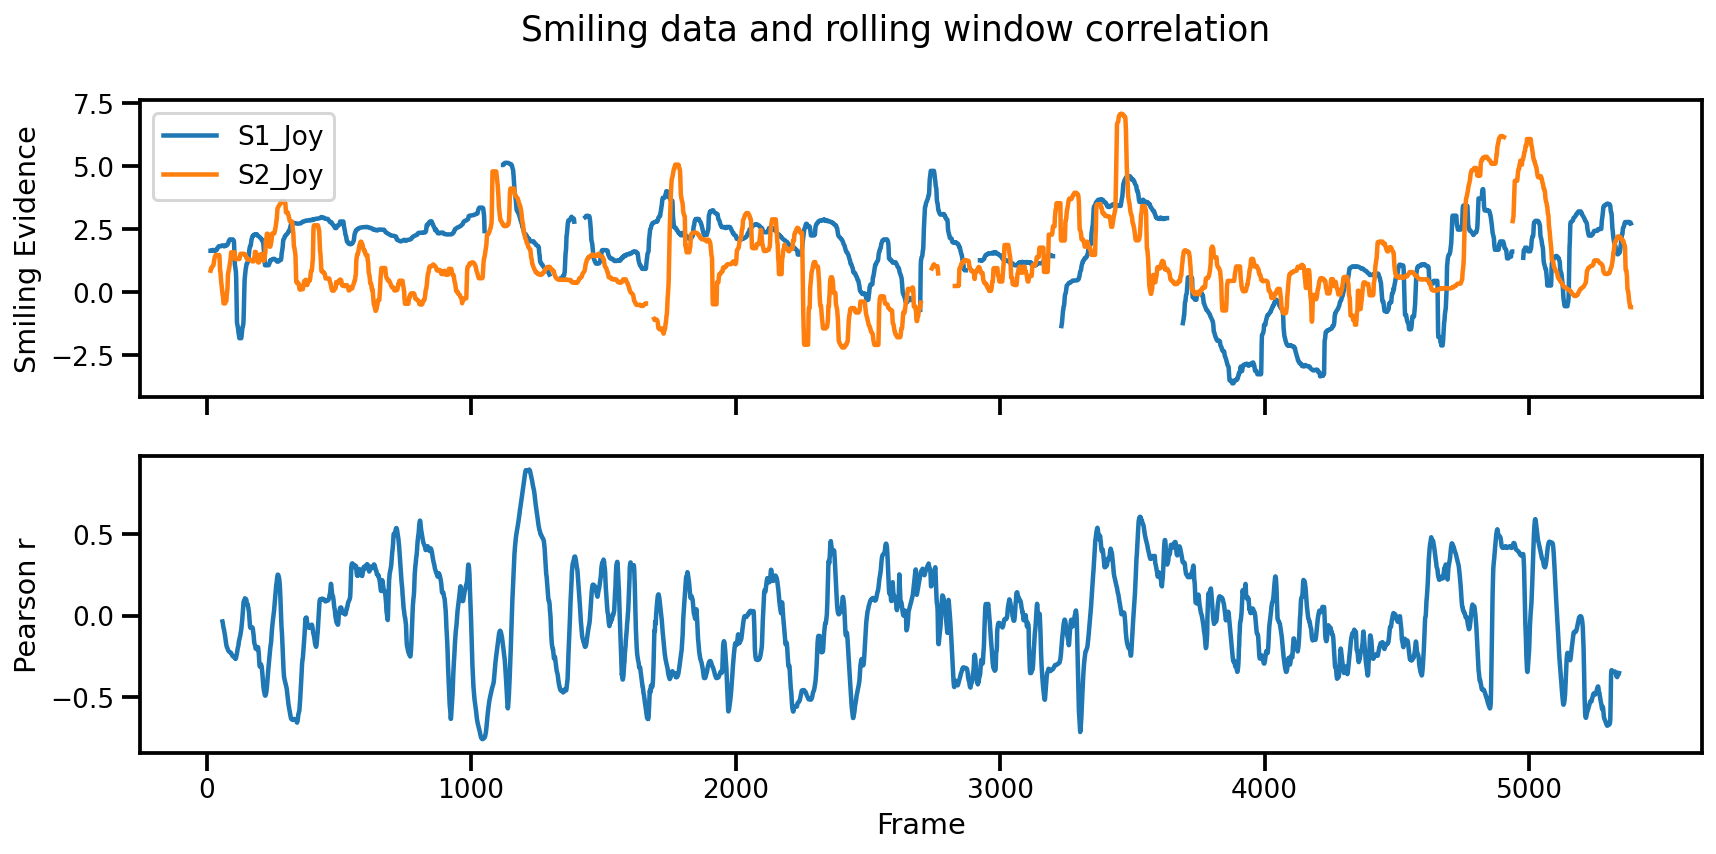

In [10]:
# Set window size to compute moving window synchrony.
r_window_size = 120
# Interpolate missing data.
df_interpolated = df.interpolate()
# Compute rolling window synchrony
rolling_r = df_interpolated['S1_Joy'].rolling(window=r_window_size, center=True).corr(df_interpolated['S2_Joy'])
f,ax=plt.subplots(2,1,figsize=(14,6),sharex=True)
df.rolling(window=30,center=True).median().plot(ax=ax[0])
ax[0].set(xlabel='Frame',ylabel='Smiling Evidence')
rolling_r.plot(ax=ax[1])
ax[1].set(xlabel='Frame',ylabel='Pearson r')
plt.suptitle("Smiling data and rolling window correlation")
plt.show()

# Time Lagged Cross Correlation

ipykernel_launcher:32: UserWarning: FixedFormatter should only be used together with FixedLocator


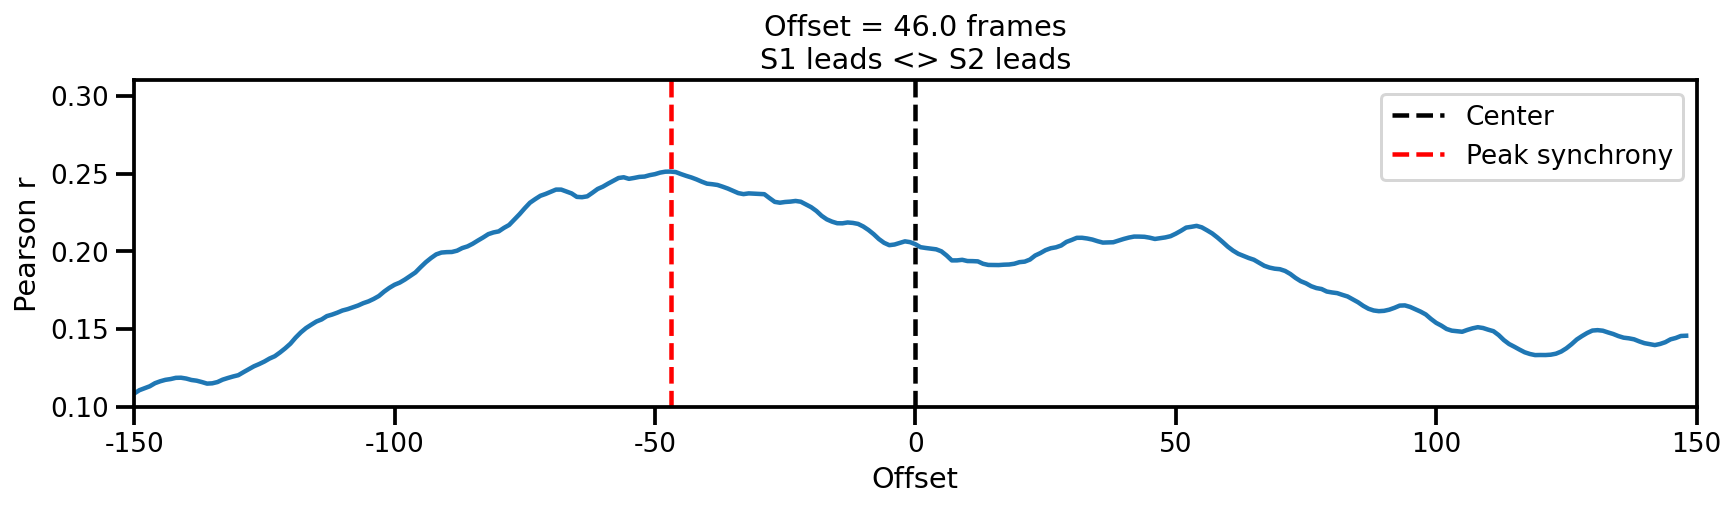

In [11]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length

    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))

d1 = df['S1_Joy']
d2 = df['S2_Joy']
seconds = 5
fps = 30
rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
offset = np.floor(len(rs)/2)-np.argmax(rs)
f,ax=plt.subplots(figsize=(14,3))
ax.plot(rs)
ax.axvline(np.ceil(len(rs)/2),color='k',linestyle='--',label='Center')
ax.axvline(np.argmax(rs),color='r',linestyle='--',label='Peak synchrony')
ax.set(title=f'Offset = {offset} frames\nS1 leads <> S2 leads',ylim=[.1,.31],xlim=[0,300], xlabel='Offset',ylabel='Pearson r')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);
plt.legend()

In [15]:
# Plotly interactive plot
import plotly.express as px
df = pd.DataFrame({"rs": rs, "offset": range(-int(seconds*fps-1),int(seconds*fps))})
fig = px.line(df, x="offset", y="rs", title=f'Offset = {offset} frames\nS1 leads <> S2 leads')
fig.show()

## Windowed time lagged cross correlation

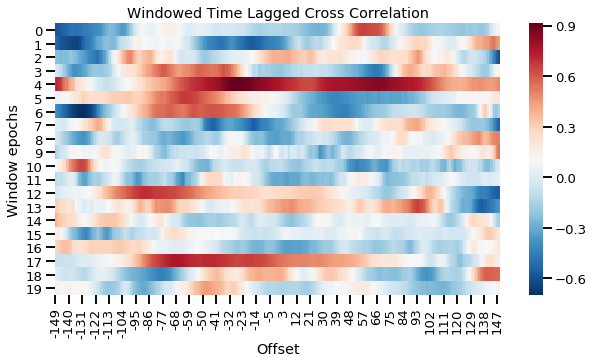

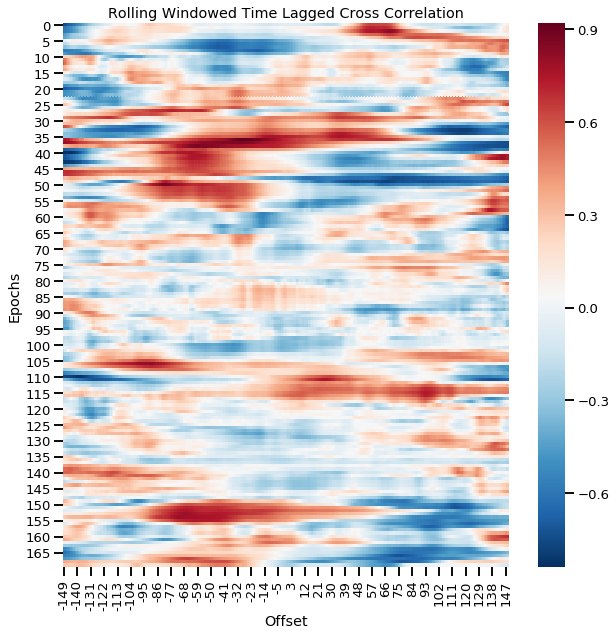

In [120]:
# Windowed time lagged cross correlation
seconds = 5
fps = 30
no_splits = 20
samples_per_split = df.shape[0]/no_splits
rss=[]
for t in range(0, no_splits):
    d1 = df['S1_Joy'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    d2 = df['S2_Joy'].loc[(t)*samples_per_split:(t+1)*samples_per_split]
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
rss = pd.DataFrame(rss)
f,ax = plt.subplots(figsize=(10,5))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Windowed Time Lagged Cross Correlation',xlim=[0,300], xlabel='Offset',ylabel='Window epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);

# Rolling window time lagged cross correlation
seconds = 5
fps = 30
window_size = 300 #samples
t_start = 0
t_end = t_start + window_size
step_size = 30
rss=[]
while t_end < 5400:
    d1 = df['S1_Joy'].iloc[t_start:t_end]
    d2 = df['S2_Joy'].iloc[t_start:t_end]
    rs = [crosscorr(d1,d2, lag, wrap=False) for lag in range(-int(seconds*fps-1),int(seconds*fps))]
    rss.append(rs)
    t_start = t_start + step_size
    t_end = t_end + step_size
rss = pd.DataFrame(rss)

f,ax = plt.subplots(figsize=(10,10))
sns.heatmap(rss,cmap='RdBu_r',ax=ax)
ax.set(title=f'Rolling Windowed Time Lagged Cross Correlation',xlim=[0,300], xlabel='Offset',ylabel='Epochs')
ax.set_xticklabels([int(item-150) for item in ax.get_xticks()]);

# Dynamic Time Warping

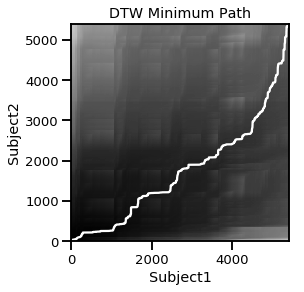

In [123]:
from dtw import dtw,accelerated_dtw

d1 = df['S1_Joy'].interpolate().values
d2 = df['S2_Joy'].interpolate().values
d, cost_matrix, acc_cost_matrix, path = accelerated_dtw(d1,d2, dist='euclidean')

plt.imshow(acc_cost_matrix.T, origin='lower', cmap='gray', interpolation='nearest')
plt.plot(path[0], path[1], 'w')
plt.xlabel('Subject1')
plt.ylabel('Subject2')
plt.title('DTW Minimum Path')
plt.show()

The fact that signal is pulled towards Subject1 indicates that the signal from subject 2 is pulled towards subject1, indicating that subject 1 is the leader. 

# instantaneous phase synchrony

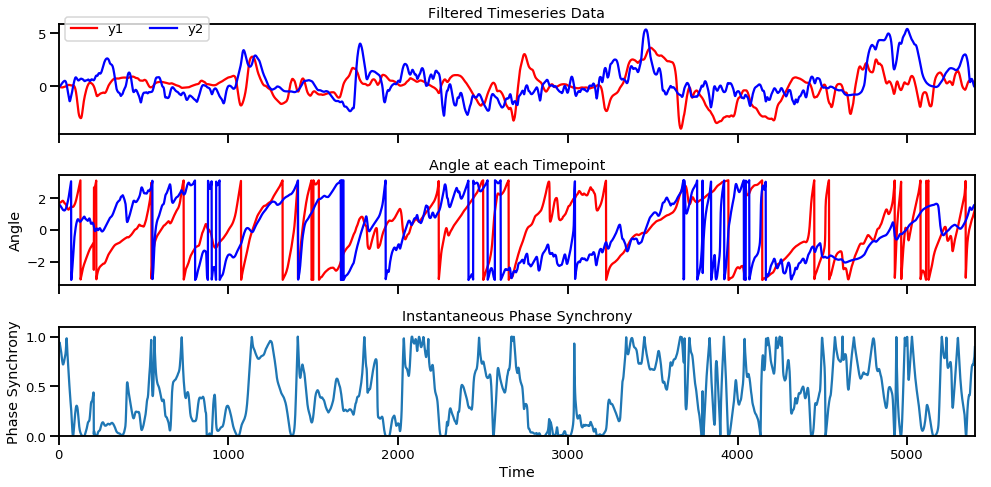

In [131]:
from scipy.signal import hilbert, butter, filtfilt
from scipy.fftpack import fft,fftfreq,rfft,irfft,ifft
import numpy as np
import seaborn as sns
import pandas as pd
import scipy.stats as stats
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

lowcut  = .01
highcut = .5
fs = 30.
order = 1
d1 = df['S1_Joy'].interpolate().values
d2 = df['S2_Joy'].interpolate().values
y1 = butter_bandpass_filter(d1,lowcut=lowcut,highcut=highcut,fs=fs,order=order)
y2 = butter_bandpass_filter(d2,lowcut=lowcut,highcut=highcut,fs=fs,order=order)

al1 = np.angle(hilbert(y1),deg=False)
al2 = np.angle(hilbert(y2),deg=False)
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
N = len(al1)

# Plot results
f,ax = plt.subplots(3,1,figsize=(14,7),sharex=True)
ax[0].plot(y1,color='r',label='y1')
ax[0].plot(y2,color='b',label='y2')
ax[0].legend(bbox_to_anchor=(0., 1.02, 1., .102),ncol=2)
ax[0].set(xlim=[0,N], title='Filtered Timeseries Data')
ax[1].plot(al1,color='r')
ax[1].plot(al2,color='b')
ax[1].set(ylabel='Angle',title='Angle at each Timepoint',xlim=[0,N])
phase_synchrony = 1-np.sin(np.abs(al1-al2)/2)
ax[2].plot(phase_synchrony)
ax[2].set(ylim=[0,1.1],xlim=[0,N],title='Instantaneous Phase Synchrony',xlabel='Time',ylabel='Phase Synchrony')
plt.tight_layout()
plt.show()